In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import re
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [4]:
# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets


/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


# Data Preparation

Research Question: How do the race of the patient and their A1C test results jointly influence the duration of their hospital stay?

VARIABLES OF INTEREST:
Factor 1 (IV1): race
Caucasian, Asian, African American, Hispanic, Other

Factor 2 (IV2): A1C test result - a1c
>8%, 7%, Normal, None (not measure)

Dependent Variable- time_in_hospital
Duration hospital stay

In [5]:
df1 = pd.DataFrame(X)
df1

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
101762,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,NaN,...,No,No,Steady,No,No,No,No,No,No,Yes
101763,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
101764,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,...,No,No,Up,No,No,No,No,No,Ch,Yes


In [6]:
df2 = pd.DataFrame(y)
df2

,readmitted
0,NO
1,>30
2,NO
3,NO
4,NO
...,...
101761,>30
101762,NO
101763,NO
101764,NO


In [7]:
# examine a subset of the dataset focusing on the variables of interest
new_df = df1[['race', 'A1Cresult', 'time_in_hospital']]
new_df

,race,A1Cresult,time_in_hospital
0,Caucasian,None,1
1,Caucasian,None,3
2,AfricanAmerican,None,2
3,Caucasian,None,2
4,Caucasian,None,1
...,...,...,...
101761,AfricanAmerican,>8,3
101762,AfricanAmerican,None,5
101763,Caucasian,None,1
101764,Caucasian,None,10


In [8]:
# Cleaning dataset
for c in new_df.columns:
  print(f"{c}: {type(new_df[c][0])}")

race: <class 'str'>
A1Cresult: <class 'str'>
time_in_hospital: <class 'numpy.int64'>


In [9]:
# Identify missing values
missing_values = new_df.isnull().sum()
missing_values

race                2273
A1Cresult              0
time_in_hospital       0
dtype: int64

In [10]:
new_df = new_df.dropna()
new_df.shape

(99493, 3)

In [11]:
def clean_value(value):
    cleaned_value = re.sub(r'\s+|[^a-zA-Z0-9]', '', str(value))
    return cleaned_value

new_df = new_df.rename(mapper=clean_value, axis=1)
new_df

,race,A1Cresult,timeinhospital
0,Caucasian,None,1
1,Caucasian,None,3
2,AfricanAmerican,None,2
3,Caucasian,None,2
4,Caucasian,None,1
...,...,...,...
101761,AfricanAmerican,>8,3
101762,AfricanAmerican,None,5
101763,Caucasian,None,1
101764,Caucasian,None,10


# Assumption Checks

Normality test using the Shapiro-Wilk Test

Null Hypothesis (H0): The data follows a normal distribution.

Alternative Hypothesis (H1): The data does not follow a normal distribution.

In [12]:
stats.shapiro(new_df['timeinhospital'])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8867098093032837, pvalue=0.0)

In [13]:
import matplotlib.pyplot as plt

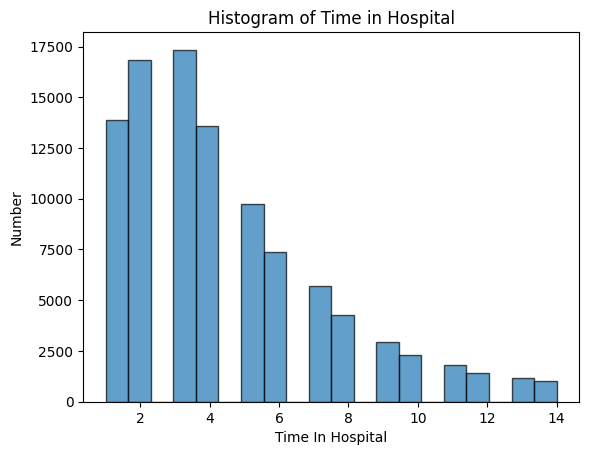

In [14]:
plt.hist(new_df['timeinhospital'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Time in Hospital')
plt.xlabel('Time In Hospital')
plt.ylabel('Number')
plt.show()

In [15]:
groups = new_df.groupby(['race', 'A1Cresult'])

for (race_status, A1C_status), group_df in groups:
    _, p_value = stats.shapiro(group_df['timeinhospital'])

    print(f"Group ({race_status}, {A1C_status}):")
    print(f"P-value from Shapiro-Wilk Test: {p_value}\n")

Group (AfricanAmerican, >7):
P-value from Shapiro-Wilk Test: 1.8906119489850806e-16

Group (AfricanAmerican, >8):
P-value from Shapiro-Wilk Test: 6.7359146155303186e-34

Group (AfricanAmerican, None):
P-value from Shapiro-Wilk Test: 0.0

Group (AfricanAmerican, Norm):
P-value from Shapiro-Wilk Test: 2.9696700824519264e-25

Group (Asian, >7):
P-value from Shapiro-Wilk Test: 0.0023467366117984056

Group (Asian, >8):
P-value from Shapiro-Wilk Test: 2.233798113593366e-05

Group (Asian, None):
P-value from Shapiro-Wilk Test: 2.6558121925662052e-21

Group (Asian, Norm):
P-value from Shapiro-Wilk Test: 0.0007482930086553097

Group (Caucasian, >7):
P-value from Shapiro-Wilk Test: 1.7925673399754353e-38

Group (Caucasian, >8):
P-value from Shapiro-Wilk Test: 0.0

Group (Caucasian, None):
P-value from Shapiro-Wilk Test: 0.0

Group (Caucasian, Norm):
P-value from Shapiro-Wilk Test: 1.930148504761003e-41

Group (Hispanic, >7):
P-value from Shapiro-Wilk Test: 2.1721559733123286e-06

Group (Hispanic

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


From the Shapiro-Wilk test, we can see that the p value is less than 0.05, therefore, we reject the null hypothesis.
The graph visualization shows that the histogram is right skewed.

## Insights
The p-value for the Shapiro-Wilk test for the time in hospital is 0.0 which is less than 0.05. Therefore, the null hypothesis is rejected. The data does not have a normal distribution. This is demonstrated by the histogram of time in hospital which has a right-skew.

# Homoscedasticity (Equal Variances) Levene/Bartlett test

Null Hypothesis (H0): The variances are equal across groups

Alternative Hypothesis (H1): The variances are not equal across all groups

In [16]:
new_df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [17]:
new_df['A1Cresult'].value_counts()

None    82897
>8       7961
Norm     4905
>7       3730
Name: A1Cresult, dtype: int64

In [18]:
# Levene's Test
statistic, p_value = stats.levene(
    new_df['timeinhospital'][new_df['race'] == 'Caucasian'][new_df['A1Cresult'] == 'None'],
    new_df['timeinhospital'][new_df['race'] == 'Caucasian'][new_df['A1Cresult'] == '>8'],
    new_df['timeinhospital'][new_df['race'] == 'Caucasian'][new_df['A1Cresult'] == 'Norm'],
    new_df['timeinhospital'][new_df['race'] == 'Caucasian'][new_df['A1Cresult'] == '>7'],
    new_df['timeinhospital'][new_df['race'] == 'AfricanAmerican'][new_df['A1Cresult'] == 'None'],
    new_df['timeinhospital'][new_df['race'] == 'AfricanAmerican'][new_df['A1Cresult'] == '>8'],
    new_df['timeinhospital'][new_df['race'] == 'AfricanAmerican'][new_df['A1Cresult'] == 'Norm'],
    new_df['timeinhospital'][new_df['race'] == 'AfricanAmerican'][new_df['A1Cresult'] == '>7'],
    new_df['timeinhospital'][new_df['race'] == 'Hispanic'][new_df['A1Cresult'] == 'None'],
    new_df['timeinhospital'][new_df['race'] == 'Hispanic'][new_df['A1Cresult'] == '>8'],
    new_df['timeinhospital'][new_df['race'] == 'Hispanic'][new_df['A1Cresult'] == 'Norm'],
    new_df['timeinhospital'][new_df['race'] == 'Hispanic'][new_df['A1Cresult'] == '>7'],
    new_df['timeinhospital'][new_df['race'] == 'Other'][new_df['A1Cresult'] == 'None'],
    new_df['timeinhospital'][new_df['race'] == 'Other'][new_df['A1Cresult'] == '>8'],
    new_df['timeinhospital'][new_df['race'] == 'Other'][new_df['A1Cresult'] == 'Norm'],
    new_df['timeinhospital'][new_df['race'] == 'Other'][new_df['A1Cresult'] == '>7'],
    new_df['timeinhospital'][new_df['race'] == 'Asian'][new_df['A1Cresult'] == 'None'],
    new_df['timeinhospital'][new_df['race'] == 'Asian'][new_df['A1Cresult'] == '>8'],
    new_df['timeinhospital'][new_df['race'] == 'Asian'][new_df['A1Cresult'] == 'Norm'],
    new_df['timeinhospital'][new_df['race'] == 'Asian'][new_df['A1Cresult'] == '>7'],
    )

In [19]:
print(f"Satistic value: {statistic}")
print(f"Levenes Test P-value: {p_value}")

Satistic value: 7.450102003925797
Levenes Test P-value: 9.580811219790571e-21


## Insights

The p-value for the Levene's test is 9.580811219790571e-21. This value less than 0.05 which means that the null hypothesis is rejected. The variances are not equal across groups.

# ANOVA Test

Two-Way Parametric ANOVA
If the parametric ANOVA test has statistically significant results, a post-hoc test will be needed.

Null Hypothesis 1: The population means of race are equal

Null Hypothesis 2: The population means of A1cresult are equal

Null Hypothesis 3: There is no interaction between race and A1Cresult

In [20]:
# Two-Way ANOVA test
model = ols('timeinhospital ~ C(race) * C(A1Cresult)', data=new_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                             sum_sq       df           F        PR(>F)
C(race)                  641.735130      4.0   18.075566  7.501203e-15
C(A1Cresult)            3895.231358      3.0  146.287793  1.363867e-94
C(race):C(A1Cresult)     276.823623     12.0    2.599070  1.845652e-03
Residual              882895.150091  99473.0         NaN           NaN


## Insights

Hypothesis 1: The p-value for the main effect of race is 7.501203e-15. This value is below the common significane level of 0.05 which demonstrates that there is a statistical significance between the means of race. The null hypothesis is rejected.

Hypothesis 2: The p-value for the effect of A1Cresult is 1.363867e-94. This value is below the common significance level of 0.05 which demonstrates that there is a statitical significance between the means of A1Cresult. Therefore, the null hypothesis is rejected.

Hypothesis 3: The p-vaule for the interaction effect between race and A1Cresult is 1.845652e-03. This value is lower than 0.05 which means that there is a significance interaction between race and A1Cresult in their effects on time in hospital.

## Kruskal-Wallis H Test For Non-Parametric ANOVA:

Null Hypothesis: The medians of each group are the same with the same distribution

Alternative Hypothesis: At least one of the groups has a different median with a different distribution.

In [21]:
group1 = new_df['timeinhospital'][new_df['race'] == 'Caucasian'][new_df['A1Cresult'] == 'None']
group2 = new_df['timeinhospital'][new_df['race'] == 'Caucasian'][new_df['A1Cresult'] == '>8']
group3 = new_df['timeinhospital'][new_df['race'] == 'Caucasian'][new_df['A1Cresult'] == 'Norm']
group4 = new_df['timeinhospital'][new_df['race'] == 'Caucasian'][new_df['A1Cresult'] == '>7']
group5 = new_df['timeinhospital'][new_df['race'] == 'AfricanAmerican'][new_df['A1Cresult'] == 'None']
group6 = new_df['timeinhospital'][new_df['race'] == 'AfricanAmerican'][new_df['A1Cresult'] == '>8']
group7 = new_df['timeinhospital'][new_df['race'] == 'AfricanAmerican'][new_df['A1Cresult'] == 'Norm']
group8 = new_df['timeinhospital'][new_df['race'] == 'AfricanAmerican'][new_df['A1Cresult'] == '>7']
group9 = new_df['timeinhospital'][new_df['race'] == 'Hispanic'][new_df['A1Cresult'] == 'None']
group10 = new_df['timeinhospital'][new_df['race'] == 'Hispanic'][new_df['A1Cresult'] == '>8']
group11 = new_df['timeinhospital'][new_df['race'] == 'Hispanic'][new_df['A1Cresult'] == 'Norm']
group12 = new_df['timeinhospital'][new_df['race'] == 'Hispanic'][new_df['A1Cresult'] == '>7']
group13 = new_df['timeinhospital'][new_df['race'] == 'Other'][new_df['A1Cresult'] == 'None']
group14 = new_df['timeinhospital'][new_df['race'] == 'Other'][new_df['A1Cresult'] == '>8']
group15 = new_df['timeinhospital'][new_df['race'] == 'Other'][new_df['A1Cresult'] == 'Norm']
group16 = new_df['timeinhospital'][new_df['race'] == 'Other'][new_df['A1Cresult'] == '>7']
group17 = new_df['timeinhospital'][new_df['race'] == 'Asian'][new_df['A1Cresult'] == 'None']
group18 = new_df['timeinhospital'][new_df['race'] == 'Asian'][new_df['A1Cresult'] == '>8']
group19 = new_df['timeinhospital'][new_df['race'] == 'Asian'][new_df['A1Cresult'] == 'Norm']
group20 = new_df['timeinhospital'][new_df['race'] == 'Asian'][new_df['A1Cresult'] == '>7']

In [22]:
# Performing Kruskal-Wallis H Test
h_stat, p_val = stats.kruskal(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11, group12, group13, group14, group15, group15, group16, group17, group18, group19, group20)
print(f"H-statistic: {h_stat}")
print(f"P-value: {p_val}")

H-statistic: 590.5784589487168
P-value: 2.775733396643869e-112


The p-value is 2.90e-112. This value is less than 0.05 which shows that there is a statistically significant difference between the groups.
The H-statistic is 586.92, which means there is a greater variability between the groups.

# Tukey Post-hoc Test

### Hypotheses:
Null Hypothesis (H0): There is no statistical differences between the means of the groups

Alternative Hypothesis (H1): There is a statistical difference between the means of the groups

This test compares the group means of the variables in pairs

In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [24]:
# For Race
posthoc_race = pairwise_tukeyhsd(endog=new_df['timeinhospital'], groups=new_df['race'], alpha=0.05)
print("Tukey HSD test for Race:\n", posthoc_race)


Tukey HSD test for Race:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
     group1       group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
AfricanAmerican     Asian  -0.5125 0.0002 -0.8396 -0.1855   True
AfricanAmerican Caucasian  -0.1221    0.0 -0.1879 -0.0564   True
AfricanAmerican  Hispanic   -0.448    0.0 -0.6378 -0.2582   True
AfricanAmerican     Other  -0.2343 0.0278 -0.4523 -0.0163   True
          Asian Caucasian   0.3904 0.0087  0.0673  0.7135   True
          Asian  Hispanic   0.0646 0.9894 -0.3043  0.4335  False
          Asian     Other   0.2783 0.2778 -0.1059  0.6624  False
      Caucasian  Hispanic  -0.3258    0.0 -0.5087  -0.143   True
      Caucasian     Other  -0.1121 0.5995 -0.3241  0.0998  False
       Hispanic     Other   0.2137 0.2175 -0.0631  0.4905  False
----------------------------------------------------------------


In [25]:
# For A1C Result
posthoc_a1c = pairwise_tukeyhsd(endog=new_df['timeinhospital'], groups=new_df['A1Cresult'], alpha=0.05)
print("\nTukey HSD test for A1C Result:\n", posthoc_a1c)


Tukey HSD test for A1C Result:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    >7     >8   -0.157 0.0397 -0.3089 -0.0051   True
    >7   None   -0.588    0.0 -0.7162 -0.4598   True
    >7   Norm   0.0238  0.983 -0.1425  0.1902  False
    >8   None   -0.431    0.0 -0.5209 -0.3412   True
    >8   Norm   0.1808 0.0046  0.0418  0.3198   True
  None   Norm   0.6118    0.0  0.4993  0.7243   True
----------------------------------------------------


## Insights

Tukey results for race:

- The p-value for the comparison between African American and Asian is 0.0002, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

- The p-value for the comparison between African American and Caucasian is 0.0, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

- The p-value for the comparison between African American and Hispanic is 0.0, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

- The p-value for the comparison between African American and Other is 0.0278, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

- The p-value for the comparison between Asian and Caucasian is 0.0087, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

- The p-value for the comparison between Asian and Hispanic is 0.9894, which is greater than 0.05. There is no statistical significance and the null hypothesis is not rejected.

- The p-value for the comparison between Asian and Other is 0.2778, which is greater than 0.05. There is no statistical significance and the null hypothesis is not rejected.

- The p-value for the comparison between Caucasian and Hispanic is 0.0, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

- The p-value for the comparison between Caucasian and Other is 0.5995, which is greater than 0.05. There is no statistical significance and the null hypothesis is not rejected.

- The p-value for the comparison between Hispanic and Other is 0.2175, which is greater than 0.05. There is no statistical significance and the null hypothesis is not rejected.

Tukey HSD test for A1C Results:

- The p-value for the comparison between >7 and >8 is 0.0397, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

The p-value for the comparison between >7 and None is 0.0, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

The p-value for the comparison between >7 and Norm is 0.983, which is greater than 0.05. There is no statistical significance and the null hypothesis is not rejected.

The p-value for the comparison between >8 and None is 0.0, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

The p-value for the comparison between >8 and None is 0.0046, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.

The p-value for the comparison between None and Norm is 0.0, which is less than 0.05. There is a statistical significance and the null hypothesis is rejected.